# Advanced Lane Lines Finding 

In this project our goal is to write a software pipeline to identify the road lane lines in a video from a front-facing camera on a car. We will detect and calculate curved line as well as detecting the relative position of the car with regard to the center of the road. In order to acheive please find bellow our action plan :

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image. 
4. Apply a perspective transform to rectify our image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera Calibration

### Imports

Thanks to OpenCV most of the function needed for us to Calibrating our camera will be native OpenCV function , lets do our imports!

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

### Define our calibration function

In order for use to calibrate our camera we will use a chessboard of wich we know the dimensions and number of intercection.
The number of corners in any given row will be noted nx. Similarly,the number of corners in a given column will be noted ny.
Taking different picture of the chessboard under different angles we will allow us to calibrate our camera.

In [366]:
def camera_calibration(images, nx, ny):
    
    #Prepare object points
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    
    for sample_img in images:
        
        #read image
        img = cv2.imread(sample_img)       
        #get image size
        img_size = (img.shape[1], img.shape[0])  
        #convert our image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      
        #find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #if corners found
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    #calculate the camera calibration matrix and the distortion coefficient based on our objectpoint and image points
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)   
    return mtx, dist

In [367]:
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

Now that we have been calculating the calibration matrix and the distortion coefficients we can know undistorted image comming from the camera.

## 2. Image distortion
Lets use the previous calibration matrix and the distortion coefficients to build an image undistort function

In [368]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Apply a distortion correction to a raw image

(-0.5, 1279.5, 719.5, -0.5)

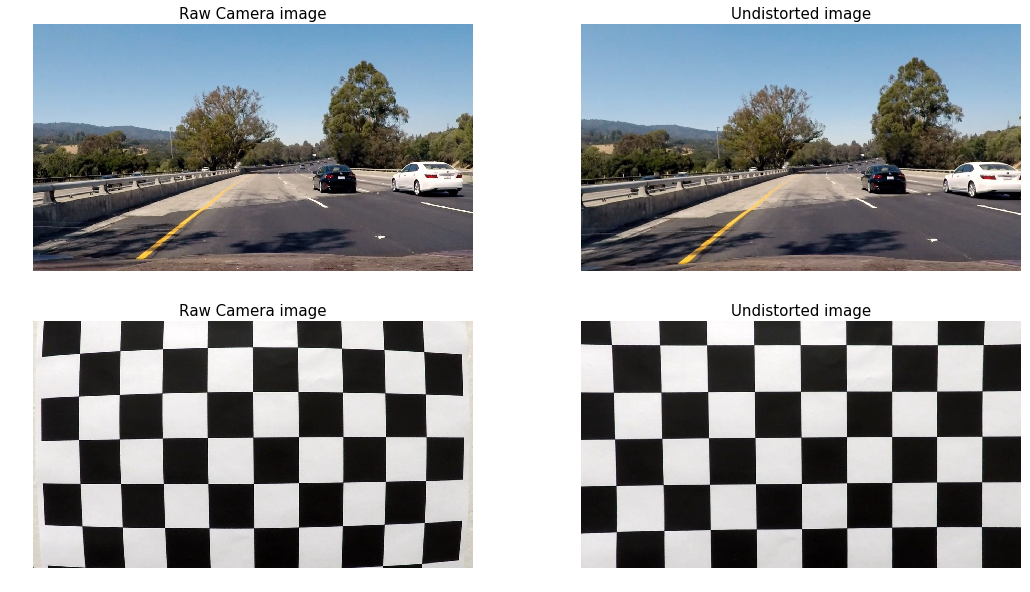

In [369]:
#Lets apply a distortion correction to a raw image and check the result
test_img = plt.imread("test_images/test4.jpg")
undist_test_img = undistort(test_img)

chess = plt.imread("camera_cal/calibration1.jpg")
undist_chess = undistort(chess)

fig = plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
plt.imshow(test_img)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(undist_test_img)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(chess)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(undist_chess)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')

We can know undistort images from the camera and start to work on our pipeline ! Please note that I have displayed a chessboard image so that the undistortion get more visible for our human eyes but it can be seen also on our test image looking at the car hood for instance.

## 3.  Creating a thresholded binary image 

### Colorspace 
In this section we will explore different colorpsace and select the one that will be the most useful for us to detect the lane line.

(-0.5, 1279.5, 719.5, -0.5)

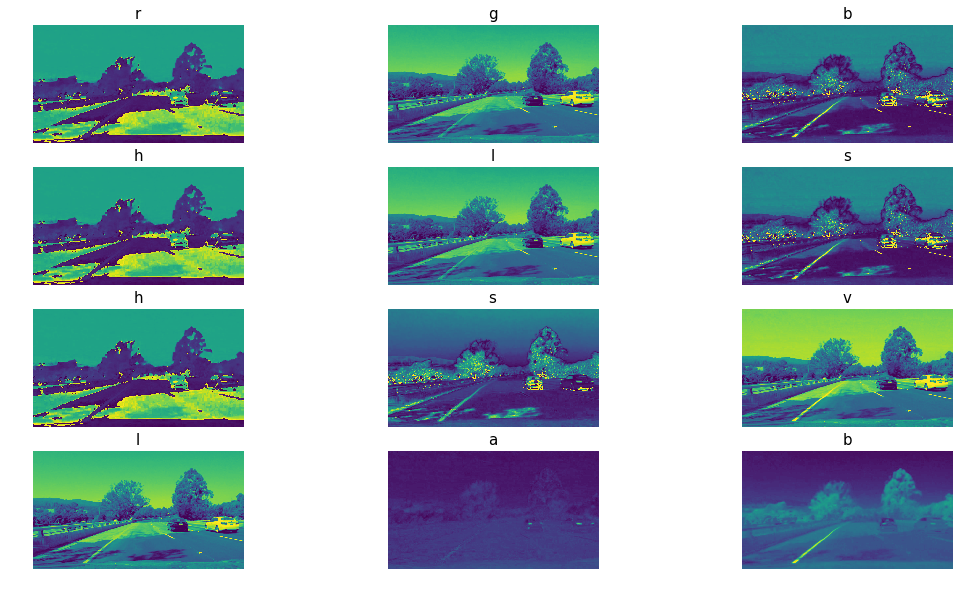

In [370]:
#initial RGB image
rgb = test_img

r_channel = hls[:,:,0]
g_channel = hls[:,:,1]
b_channel = hls[:,:,2]

#HLS colorspace
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

hls_h_channel = hls[:,:,0]
hls_l_channel = hls[:,:,1]
hls_s_channel = hls[:,:,2]

#HSV colorspace
hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)

hsv_h_channel = hsv[:,:,0] #h – Hue ( Dominant Wavelength ).
hsv_s_channel = hsv[:,:,1] #s – Saturation ( Purity / shades of the color ).
hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).

#LAB colorspace
lab = cv2.cvtColor(test_img, cv2.COLOR_RGB2Lab)

lab_l_channel = lab[:,:,0] #l – Lightness ( Intensity ).
lab_a_channel = lab[:,:,1] #a – color component ranging from Green to Magenta.
lab_b_channel = lab[:,:,2] #b – color component ranging from Blue to Yellow.


fig = plt.figure(figsize=(18, 10))
#rgb
plt.subplot(4,3,1)
plt.imshow(r_channel)
plt.title('r',fontsize=15)
plt.axis('off')
plt.subplot(4,3,2)
plt.imshow(g_channel)
plt.title('g',fontsize=15)
plt.axis('off')
plt.subplot(4,3,3)
plt.imshow(b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

#hls
plt.subplot(4,3,4)
plt.imshow(hls_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(4,3,5)
plt.imshow(hls_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(4,3,6)
plt.imshow(hls_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')

#hsv
plt.subplot(4,3,7)
plt.imshow(hsv_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(4,3,8)
plt.imshow(hsv_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')
plt.subplot(4,3,9)
plt.imshow(hsv_v_channel)
plt.title('v',fontsize=15)
plt.axis('off')

#lab
plt.subplot(4,3,10)
plt.imshow(lab_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(4,3,11)
plt.imshow(lab_a_channel)
plt.title('a',fontsize=15)
plt.axis('off')
plt.subplot(4,3,12)
plt.imshow(lab_b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

We can see that the hls s channel give pretty consistent result for both blank and white line , without being too much impacted by shadow. the LAB B channel sounds pretty good at detecting yellow lane as well and respectively the l channel for the white lane.Lets see if we can filter the hls_l_channel and the lab_b_channel to further improve the results.

#### Thresholding the hls l channel

In [371]:
#convert rgb image to hls , isolate the l channel , thershold it and return a binary image

def img_to_threshold_hls_l(img, min=215, max=255):
    # convert img to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #isolate the l channel
    hls_l = hls[:,:,1]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(hls_l)
    #threshold the l channel and return a binary image
    thresholded_img[(hls_l > min) & (hls_l <= max)] = 1
    return thresholded_img

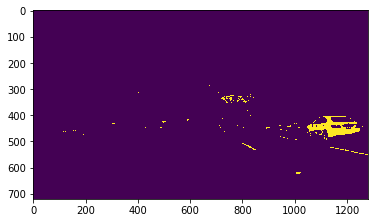

In [372]:
plt.imshow(img_to_threshold_hls_l(test_img))

We can see that our thresholding make a good job at detecting the white line

#### Thresholding the lab b channel

In [373]:
#convert rgb image to lab , isolate the b channel , thershold it and return a binary image

def img_to_threshold_lab_b(img, min=160, max=255):
    # convert img to lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    #isolate the b channel
    lab_b = lab[:,:,2]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(lab_b)
    #thershold the s channel and return a binary image
    thresholded_img[(lab_b > min) & (lab_b <= max)] = 1
    return thresholded_img

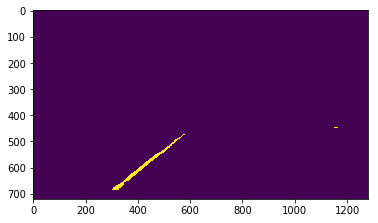

In [374]:
plt.imshow(img_to_threshold_lab_b(test_img))

We can clearly see that this thresholding make a good job at detecting the yellow line.

#### Combining the color channels

In [375]:
def augmented_colorspace(img):
    hls_l = img_to_threshold_hls_l(img)
    lab_b = img_to_threshold_lab_b(img)
    combined_binary = np.zeros_like(lab_b)
    combined_binary[(hls_l == 1) | (lab_b == 1)] = 1
    return combined_binary

##### Display the result

(-0.5, 1279.5, 719.5, -0.5)

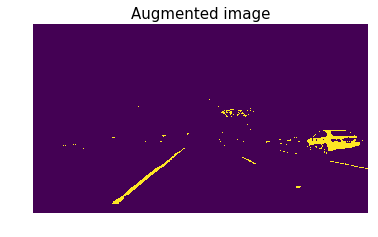

In [376]:
augmented_image = augmented_colorspace(test_img)
plt.imshow(augmented_image)
plt.title('Augmented image',fontsize=15)
plt.axis('off')

Alright the result look very promising as we can easily detect both lines lets continue building our pipeline !

### Gradient

lets use the sobel operator at the heart of the Canny edge detection algorithm to compute vertical gradients to best detect our line.

In [377]:
def sobel_x_threshold(img, thresh_min=30 , thresh_max=100):
    
    #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

(-0.5, 1279.5, 719.5, -0.5)

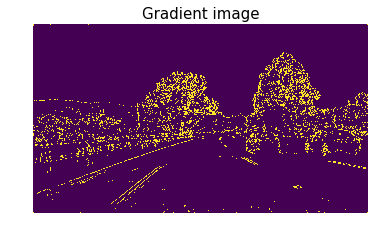

In [378]:
gradient_image = sobel_x_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Gradient image',fontsize=15)
plt.axis('off')

In [379]:
def sobel_y_threshold(img, thresh_min=20 , thresh_max=100):
    
    #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
     # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sybinary

(-0.5, 1279.5, 719.5, -0.5)

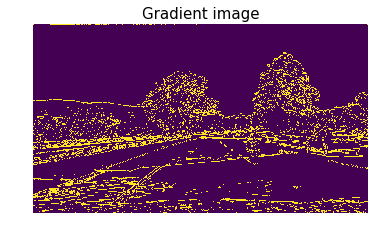

In [380]:
gradient_image = sobel_y_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Gradient image',fontsize=15)
plt.axis('off')

The gradient filtering doesn't seems to add more than the color channel filtering , lets keep only the colorspace filtering mooving forward in our pipeline 



## 4. Region of interest and Perspective transform  



At this stage we have had good results with detecting the lane, lets now definie a region of interest and do a perspective transform

In [385]:
def bird_eye_view(img):
    #set dest and source point
    src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
    dst = np.float32([(450,0),(img.shape[1]-450,0),(450,img.shape[0]),(img.shape[1]-450,img.shape[0])])
    
    #get the perpective transform Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #get theinverse transform Matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use warp the image
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

Text(0.5,1,'initial image')

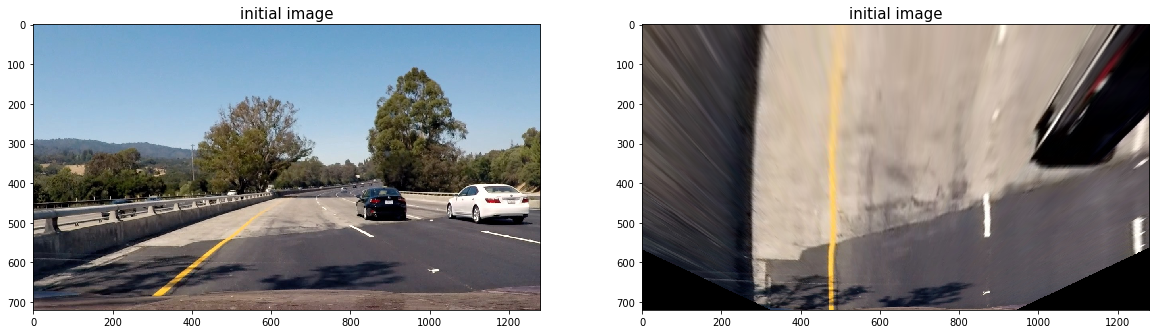

In [386]:
test_img = plt.imread("test_images/test4.jpg") 
fig = plt.figure(figsize=(20, 50))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('initial image',fontsize=15)

plt.subplot(1,2,2)
plt.imshow(bird_eye_view(test_img))
plt.title('initial image',fontsize=15)

Here are our bird eye view image ! Lets test it on other sample images !

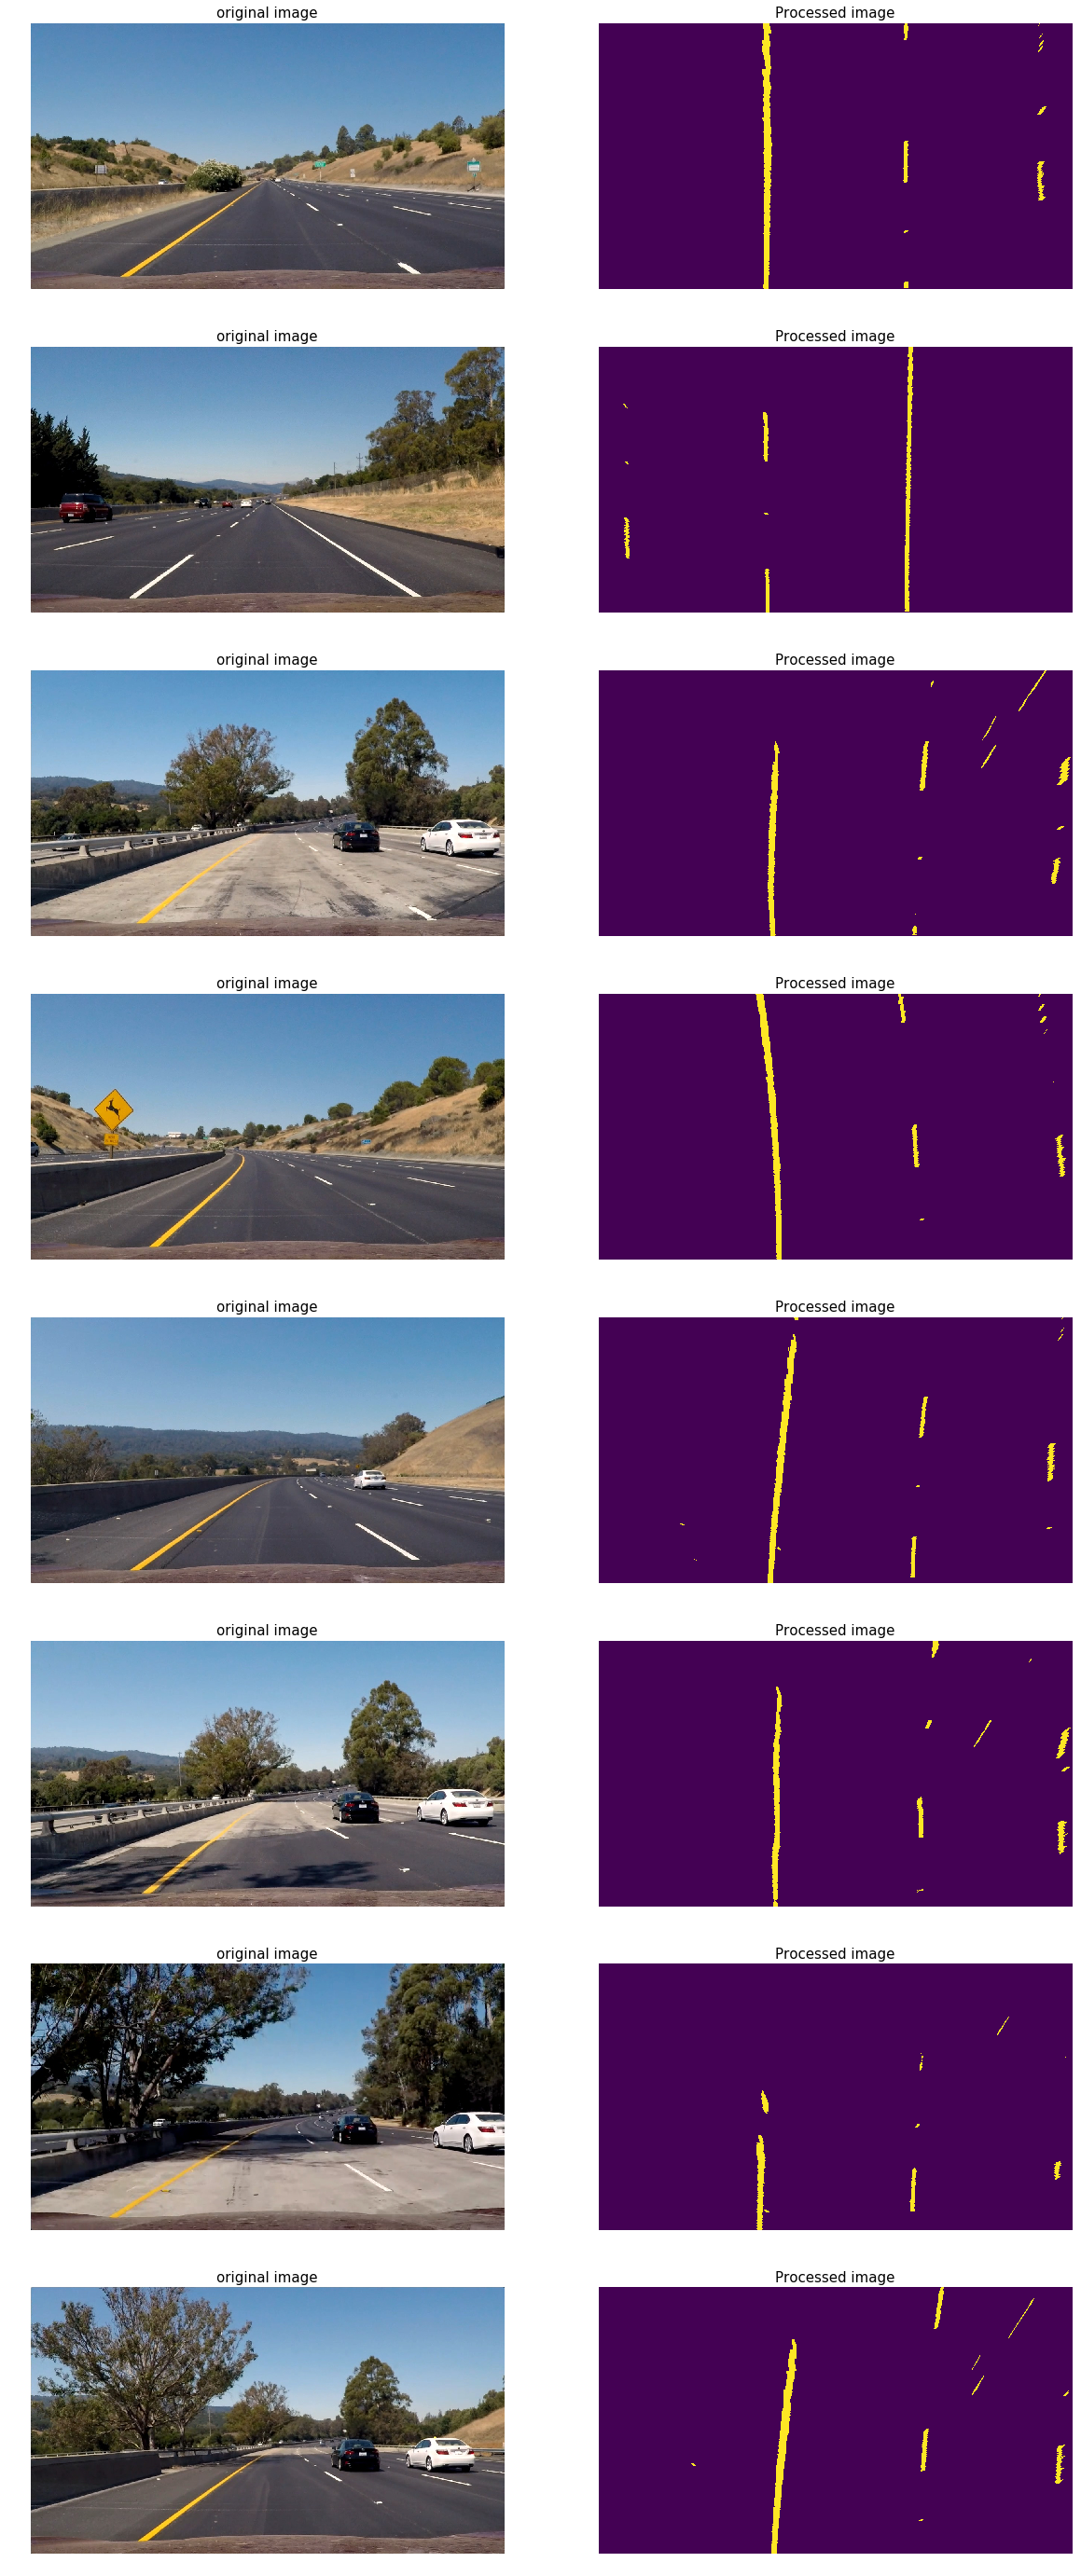

In [387]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 50))
i=1

for img_path in test_img:
    img = plt.imread(img_path)
    
    plt.subplot(8,2,i)
    plt.imshow(img)
    plt.title('original image',fontsize=15)
    plt.axis('off')
    i=i+1
    plt.subplot(8,2,i)
    plt.imshow(bird_eye_view(augmented_colorspace(img)))
    plt.title('Processed image',fontsize=15)
    plt.axis('off')
    i=i+1

Unless tiny noise , we can see that our model is doing pretty good , lets continue to design our pipeline , time to Detect lane pixels and fit to find the lane boundary !

## 5. Detect lane pixels and fit to find the lane boundary

At this stage , we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

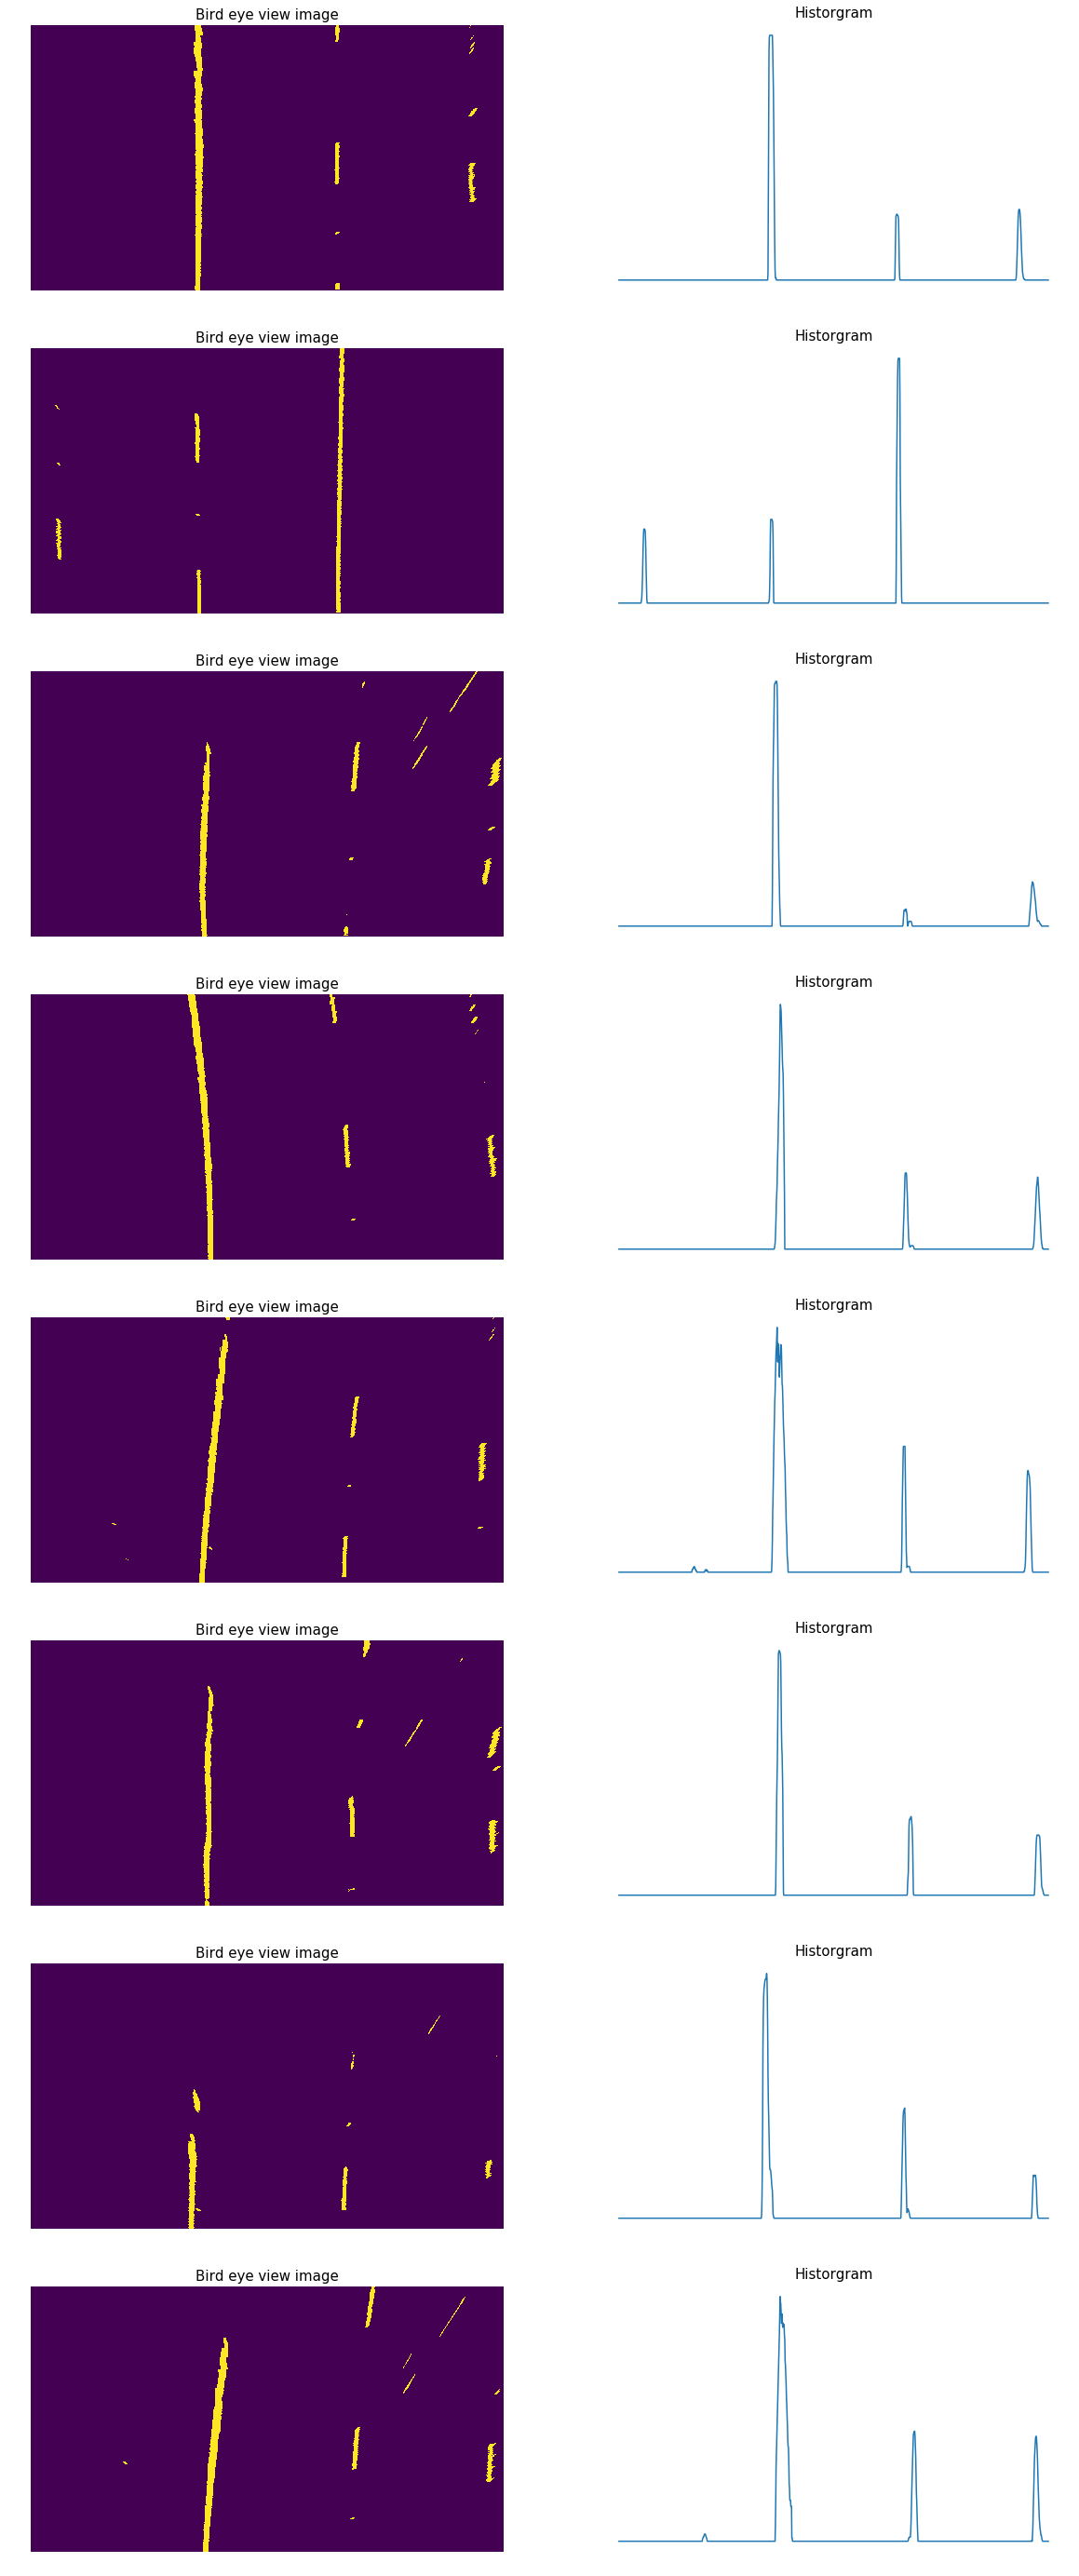

In [389]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 50))
i=1

for img_path in test_img:
    
    img = plt.imread(img_path)
    augmented_img = bird_eye_view(augmented_colorspace(img))
    
    plt.subplot(8,2,i)
    plt.imshow(augmented_img)
    plt.title('Bird eye view image',fontsize=15)
    plt.axis('off')
    i=i+1
    
    plt.subplot(8,2,i)
    histogram = np.sum(augmented_img[augmented_img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.title('Historgram',fontsize=15)
    plt.axis('off')
    i=i+1

With this histogram we will be adding up the pixel values along each column in the image. as in our thresholded binary image, pixels are either 0 or 1, the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. we can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [395]:
def polynomfit_with_sliding_windos(img):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    #save rectangle
    rectangle = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # save the rectangle
        rectangle.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle   

Visualize

In [396]:
# Generate x and y values for plotting

test_img = plt.imread("test_images/test4.jpg") 
augmented_img = bird_eye_view(test_img)

ploty = np.linspace(0, augmented_img.shape[0]-1, augmented_img.shape[0])

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle = polynomfit_with_sliding_windos(augmented_img)


# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

TypeError: expected non-empty vector for x